In [2]:
import mne
import numpy as np
from pathlib import Path

### Loading Data

In [3]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import mne

# Get the current file path
current_file_path = Path(os.path.abspath(""))

# Get the root path of the project
root_path = current_file_path.parents[0]

eeg_recordings_path = root_path / "eeg_recordings"
print(eeg_recordings_path)

/Users/anthonyricher/apps/neuro-clash/neuro_ai/eeg_recordings


In [5]:
# Load the csv data
df = pd.read_csv(eeg_recordings_path / "EEG_recording_test_raw.csv")
df.info()

# Assuming the EEG data is in columns named 'TP9', 'AF7', 'AF8', 'TP10', 'Right AUX'
# Adjust these according to your CSV file's structure
ch_names = ["TP9", "AF7", "AF8", "TP10"]
# Define channel types - assuming all channels are EEG
ch_types = ["eeg"] * len(ch_names)

# The first column is timestamps, which we don't need for the RawArray
eeg_data = df.iloc[:, 1:-1].T.values

# Create an MNE Info object (replace 256 with the actual sampling frequency)
info = mne.create_info(ch_names=ch_names, sfreq=256, ch_types=ch_types)

# Create mne RawArray
raw = mne.io.RawArray(eeg_data, info)

# Add a montage (only necessary for plotting)
montage = mne.channels.make_standard_montage("standard_1020")
raw.set_montage(montage)

# Save as FIF format
raw.save(eeg_recordings_path / "EEG_recording_test_raw.fif", overwrite=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85236 entries, 0 to 85235
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   timestamps  85236 non-null  float64
 1   Unnamed: 1  85236 non-null  float64
 2   Unnamed: 2  85236 non-null  float64
 3   Unnamed: 3  85236 non-null  float64
 4   Unnamed: 4  85236 non-null  float64
 5   Unnamed: 5  85236 non-null  float64
dtypes: float64(6)
memory usage: 3.9 MB
Creating RawArray with float64 data, n_channels=4, n_times=85236
    Range : 0 ... 85235 =      0.000 ...   332.949 secs
Ready.
Overwriting existing file.
Writing /Users/anthonyricher/apps/neuro-clash/neuro_ai/eeg_recordings/EEG_recording_test_raw.fif
Closing /Users/anthonyricher/apps/neuro-clash/neuro_ai/eeg_recordings/EEG_recording_test_raw.fif
[done]


### Filtering

In [6]:
# raw = mne.io.read_raw_fif(
#     eeg_recordings_path / "EEG_recording_test_raw.fif", preload=True
# )

# Apply band-pass filter
raw.filter(4, 40, method="iir")

# Remove frequency above 40 Hz
# raw.plot(block=True, scalings="auto", lowpass=40, title="EEG recording")

# Optionally, apply a notch filter to remove power line noise at 50 Hz or 60 Hz
# raw.notch_filter(np.arange(50, 251, 50), filter_length="auto", phase="zero")

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 40.00 Hz: -6.02, -6.02 dB



Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,7 points
Good channels,4 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,256.00 Hz
Highpass,8.00 Hz
Lowpass,40.00 Hz


### Remove Artifacts

Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components
Fitting ICA took 2.2s.
Applying ICA to Raw instance
    Transforming to ICA space (4 components)
    Zeroing out 0 ICA components
    Projecting back using 4 PCA components


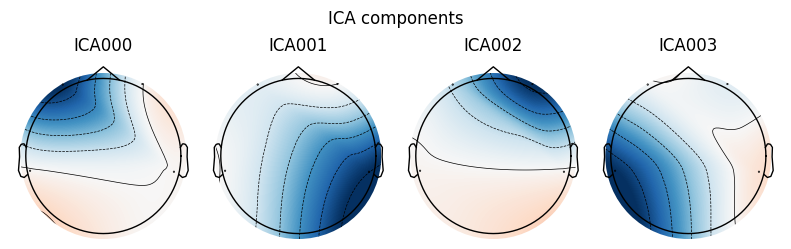

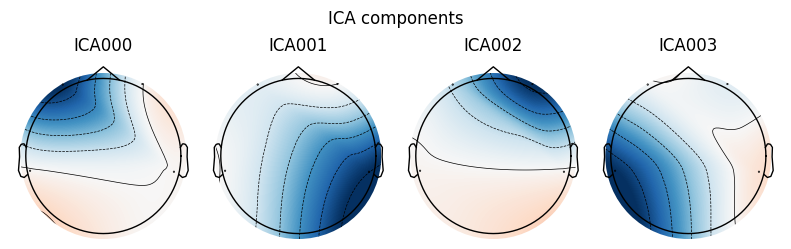

In [7]:
# Apply ICA for artifact removal
ica = mne.preprocessing.ICA(n_components=4, random_state=0)
ica.fit(raw)
raw = ica.apply(raw)
ica.plot_components()

### Segment
Segmenting events with Epochs can be used to do analysis on different patterns associated with certain activities or response

In [ ]:
# Segment the data into epochs
# events = mne.find_events(raw)
# mne.viz.plot_events(events, sfreq=raw.info["sfreq"], first_samp=raw.first_samp)

# epochs = mne.Epochs(raw, events, event_id=1)

In [ ]:
# Normalize the data
# epochs_data = epochs.get_data()
# epochs_data_normalized = (epochs_data - np.mean(epochs_data)) / np.std(epochs_data)

# # Feature extraction for concentration: Power Spectral Density (PSD) in theta and beta band 4-30
# frequencies, power = mne.time_frequency.psd_welch(epochs, fmin=12, fmax=40)

# # Extract power in the theta (4-7 Hz) and beta (13-30 Hz) bands
# theta_power = np.sum(power[(frequencies >= 4) & (frequencies <= 7)], axis=-1)
# beta_power = np.sum(power[(frequencies >= 13) & (frequencies <= 30)], axis=-1)

# # Downsample the data
# epochs_resampled = epochs.copy().resample(100)  # resample to 100Hz